https://www.tensorflow.org/tutorials/images/classification

# Import Dependencies and Load Data

In [ ]:
# Core libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from shutil import move
from time import sleep
from collections import defaultdict
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score, recall_score, f1_score

# TensorFlow and Keras
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical

# Image processing libraries
from PIL import Image
from tensorflow.io import decode_jpeg, encode_jpeg
from tensorflow.image import resize
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


# Model evaluation utilities
# from utils import PlotModelEval, PlotConfusionMatrix, PlotRandomFromEachClass

from tensorflow.keras.models import load_model

# Image augmentation layers
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom, RandomShear, Rescaling



In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

# Download dataset (commented out as it requires kagglehub)
import kagglehub
path = kagglehub.dataset_download("joebeachcapital/realwaste")
print("Path to dataset files:", path)

# Set the dataset path (adjust based on your actual path)
# filepath = "/kaggle/input/realwaste/realwaste-main/RealWaste"

Path to dataset files: /kaggle/input/realwaste


In [ ]:
filepath = "/kaggle/input/realwaste/realwaste-main/RealWaste"

In [ ]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    filepath,
    validation_split=0.2,
    subset="training",
    label_mode='categorical',
    seed=123,
    image_size=(224, 224),
    batch_size=32
)

Found 4752 files belonging to 9 classes.
Using 3802 files for training.


In [ ]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    filepath,
    validation_split=0.2,
    subset="validation",
    label_mode='categorical',
    seed=123,
    image_size=(224, 224),
    batch_size=32
)

Found 4752 files belonging to 9 classes.
Using 950 files for validation.


# EDA

In [ ]:
class_names = train_ds.class_names
class_names

['Cardboard',
 'Food Organics',
 'Glass',
 'Metal',
 'Miscellaneous Trash',
 'Paper',
 'Plastic',
 'Textile Trash',
 'Vegetation']

In [ ]:
def check_image_validity(directory):
    total_files = 0
    corrupt_files = 0

    for root, _, files in os.walk(directory):
        for file in files:
            if file.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):
                total_files += 1
                filepath = os.path.join(root, file)
                try:
                    img = Image.open(filepath)
                    img.verify()
                    img.close()

                except (IOError, SyntaxError, Image.DecompressionBombError) as e:
                    corrupt_files += 1
                    print(f"File corrupt ({corrupt_files}): {filepath} | Error: {str(e)}")
                    os.remove(filepath)

    print(f"Total files checked: {total_files}")
    print(f"Corrupt files found: {corrupt_files}")
    print(f"Valid files: {total_files - corrupt_files}")

    if corrupt_files == 0:
        print("All image files are valid!")
    else:
        print(f"Removed {corrupt_files} corrupt files.")

check_image_validity(filepath)


Total files checked: 4752
Corrupt files found: 0
Valid files: 4752
All image files are valid!


In [ ]:
for images, labels in train_ds.take(1):
    print("Images shape:", images.shape)
    print("Labels shape:", labels.shape)

Images shape: (32, 224, 224, 3)
Labels shape: (32, 9)


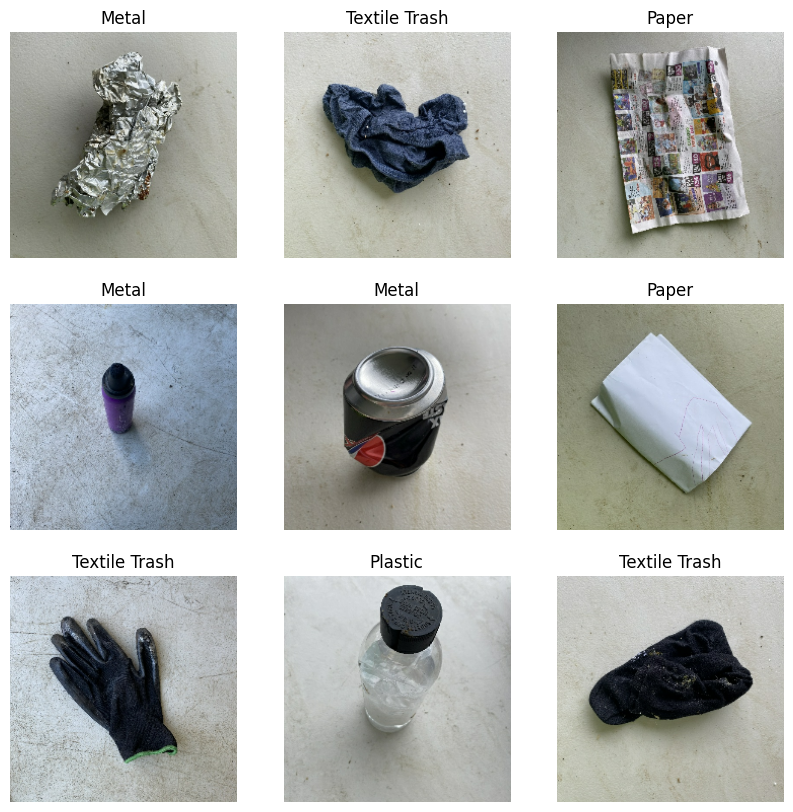

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))

    # Convert one-hot to integer index
    label_index = tf.argmax(labels[i]).numpy()
    plt.title(class_names[label_index])
    plt.axis("off")


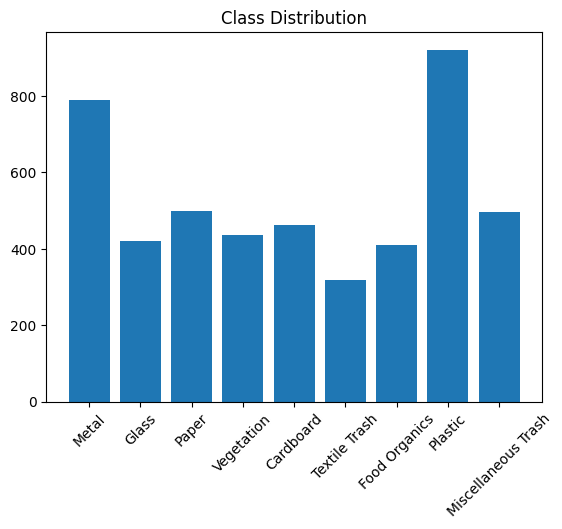

In [ ]:
class_counts = {}
for class_name in os.listdir(filepath):
    class_dir = os.path.join(filepath, class_name)
    class_counts[class_name] = len(os.listdir(class_dir))

plt.bar(class_counts.keys(), class_counts.values())
plt.xticks(rotation=45)
plt.title("Class Distribution")
plt.show()

In [ ]:
def get_class_distribution(dataset, class_names):
    class_counts = defaultdict(int)
    for images, labels in dataset:
        # Convert one-hot to index
        label_indices = tf.argmax(labels, axis=1).numpy()
        for label in label_indices:
            class_counts[class_names[label]] += 1
    return dict(class_counts)

class_names = train_ds.class_names

train_dist = get_class_distribution(train_ds, class_names)
test_dist = get_class_distribution(test_ds, class_names)

class_distribution = {
    "Class": class_names,
    "Train": [train_dist.get(cls, 0) for cls in class_names],
    "Test": [test_dist.get(cls, 0) for cls in class_names],
}

class_distribution_df = pd.DataFrame(class_distribution)
class_distribution_df

,Class,Train,Test
0,Cardboard,378,83
1,Food Organics,333,78
2,Glass,357,63
3,Metal,620,170
4,Miscellaneous Trash,390,105
5,Paper,412,88
6,Plastic,723,198
7,Textile Trash,255,63
8,Vegetation,334,102


# Preprocessing

In [ ]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1)
])

In [ ]:
normalization_layer = layers.Rescaling(1./255)
num_classes = len(class_names)

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

# Custom CNN
train_ds_custom = train_ds.map(lambda x, y: (normalization_layer(x), y)).cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
test_ds_custom = test_ds.map(lambda x, y: (normalization_layer(x), y)).cache().prefetch(buffer_size=AUTOTUNE)

# DenseNet
train_ds_densenet = train_ds.map(lambda x, y: (tf.keras.applications.densenet.preprocess_input(x), y)).cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
test_ds_densenet = test_ds.map(lambda x, y: (tf.keras.applications.densenet.preprocess_input(x), y)).cache().prefetch(buffer_size=AUTOTUNE)

# VGG16
train_ds_vgg = train_ds.map(lambda x, y: (tf.keras.applications.vgg16.preprocess_input(x), y)).cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
test_ds_vgg = test_ds.map(lambda x, y: (tf.keras.applications.vgg16.preprocess_input(x), y)).cache().prefetch(buffer_size=AUTOTUNE)

# ResNet
train_ds_resnet = train_ds.map(lambda x, y: (tf.keras.applications.resnet.preprocess_input(x), y)).cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
test_ds_resnet = test_ds.map(lambda x, y: (tf.keras.applications.resnet.preprocess_input(x), y)).cache().prefetch(buffer_size=AUTOTUNE)

# Build and Train Model

## Custom CNN

In [ ]:
num_classes = len(class_names)

model = models.Sequential([
    tf.keras.Input(shape=(224, 224, 3)),
    data_augmentation,
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(),

    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D(),

    layers.Conv2D(256, (3,3), activation='relu'),
    layers.MaxPooling2D(),

    layers.Conv2D(512, (3,3), activation='relu'),
    layers.MaxPooling2D(),

    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.2, seed=123),
    layers.Dense(num_classes, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 222, 222, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 12, 12, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 73728)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    37,749,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 9)              │         4,617 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 39,304,841 (149.94 MB)

 Trainable params: 39,304,841 (149.94 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
EPOCHS = 50

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

history = model.fit(
    train_ds_custom,
    validation_data=test_ds_custom,
    epochs=EPOCHS,
    callbacks=[early_stopping]
)


model.save('/content/custom_cnn.keras')

Epoch 1/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 47s 186ms/step - accuracy: 0.1717 - loss: 2.3332 - val_accuracy: 0.2526 - val_loss: 2.1980
Epoch 2/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 16s 131ms/step - accuracy: 0.2944 - loss: 1.9173 - val_accuracy: 0.3158 - val_loss: 1.9238
Epoch 3/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 16s 132ms/step - accuracy: 0.3896 - loss: 1.6652 - val_accuracy: 0.3853 - val_loss: 1.7901
Epoch 4/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 16s 131ms/step - accuracy: 0.4649 - loss: 1.4874 - val_accuracy: 0.4537 - val_loss: 1.5447
Epoch 5/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 15s 129ms/step - accuracy: 0.4757 - loss: 1.4246 - val_accuracy: 0.4611 - val_loss: 1.6538
Epoch 6/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 21s 130ms/step - accuracy: 0.5115 - loss: 1.3253 - val_accuracy: 0.5295 - val_loss: 1.3097
Epoch 7/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 15s 129ms/step - accuracy: 0.5449 - loss: 1.2613 - val_accuracy: 0.5253 - val_loss: 1.3826
Epoch 8/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 15s 129ms/step - accuracy: 0.5781 - loss: 1

In [ ]:
model = load_model('/content/custom_cnn.keras')

y_pred = model.predict(test_ds_custom)
y_pred = np.argmax(y_pred, axis=1)
y_true = np.concatenate([y for x, y in test_ds_custom], axis=0)
y_true = np.argmax(y_true, axis=1)

accuracy = np.sum(y_pred == y_true) / len(y_true)
print(f"Accuracy: {accuracy:.4f}")

# Classification Report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

30/30 ━━━━━━━━━━━━━━━━━━━━ 6s 136ms/step
Accuracy: 0.6558

Classification Report:
                     precision    recall  f1-score   support

          Cardboard       0.75      0.48      0.59        83
      Food Organics       0.59      0.78      0.67        78
              Glass       0.84      0.75      0.79        63
              Metal       0.59      0.74      0.65       170
Miscellaneous Trash       0.63      0.47      0.54       105
              Paper       0.54      0.73      0.62        88
            Plastic       0.69      0.61      0.65       198
      Textile Trash       0.70      0.37      0.48        63
         Vegetation       0.77      0.92      0.84       102

           accuracy                           0.66       950
          macro avg       0.68      0.65      0.65       950
       weighted avg       0.67      0.66      0.65       950



<Figure size 1000x800 with 0 Axes>

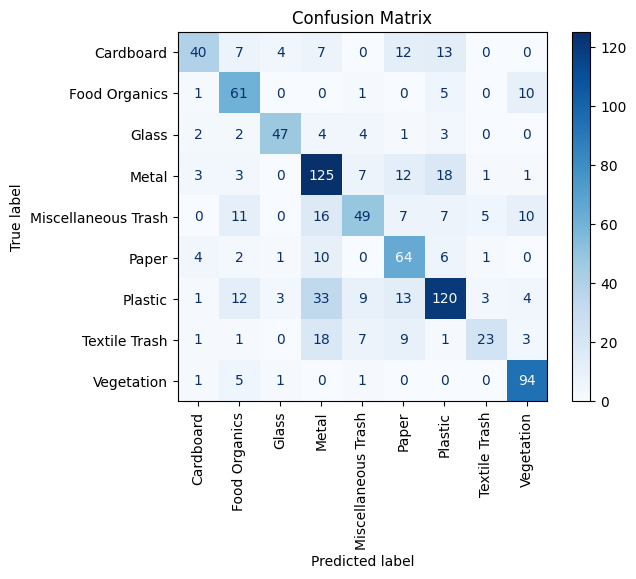

In [ ]:
cm = confusion_matrix(y_true, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
plt.figure(figsize=(10, 8))
disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical')
plt.title("Confusion Matrix")
plt.grid(False)
plt.show()


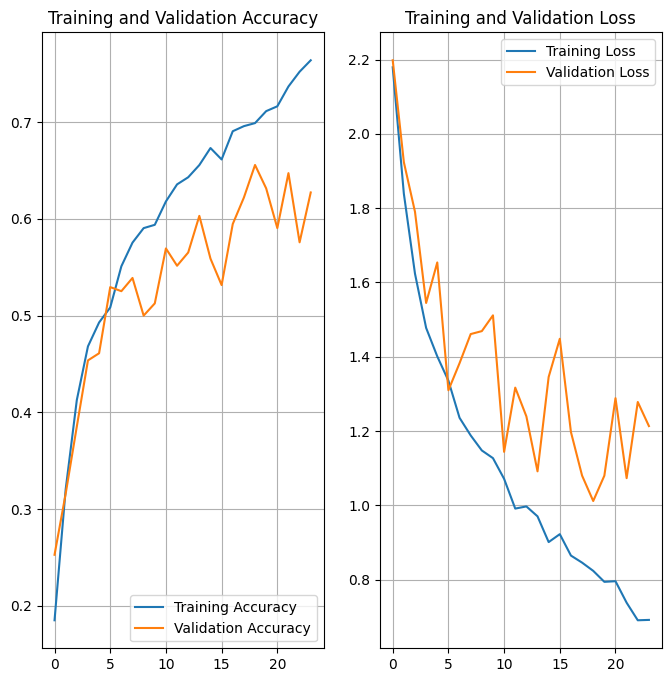

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = history.epoch

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.grid(True)
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.grid(True)
plt.title('Training and Validation Loss')
plt.show()

## Resnet50

In [ ]:
def build_resnet_model(num_classes):
    base_model = tf.keras.applications.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224, 224, 3)
    )

    base_model.trainable = True
    for layer in base_model.layers[:-10]:
        layer.trainable = False

    inputs = tf.keras.Input(shape=(224, 224, 3))
    x = data_augmentation(inputs)
    x = base_model(x)  # training=True when fine-tuning

    # Modified classifier head
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Flatten()(x)
    x = layers.Dense(1024, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = tf.keras.Model(inputs, outputs)

    # Use lower learning rate for fine-tuning
    model.compile(
        optimizer=tf.keras.optimizers.Adam(1e-4),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

num_classes = len(class_names)
model_res = build_resnet_model(num_classes)
model_res.summary()

# Train ResNet model
EPOCHS = 50

early_stopping_res = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

history_res = model_res.fit(
    train_ds_resnet,
    validation_data=test_ds_resnet,
    epochs=EPOCHS,
    callbacks=[early_stopping_res]
)

model_res.save('/content/model_res.keras')

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1024)           │     2,098,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 9)              │         9,225 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,699,209 (98.03 MB)

 Trainable params: 6,575,113 (25.08 MB)

 Non-trainable params: 19,124,096 (72.95 MB)

Epoch 1/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 61s 225ms/step - accuracy: 0.4417 - loss: 1.9211 - val_accuracy: 0.7842 - val_loss: 0.6428
Epoch 2/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 22s 186ms/step - accuracy: 0.8099 - loss: 0.5666 - val_accuracy: 0.8147 - val_loss: 0.6735
Epoch 3/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 21s 174ms/step - accuracy: 0.8830 - loss: 0.3392 - val_accuracy: 0.8137 - val_loss: 0.6859
Epoch 4/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 41s 175ms/step - accuracy: 0.9189 - loss: 0.2425 - val_accuracy: 0.8432 - val_loss: 0.6448
Epoch 5/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 21s 179ms/step - accuracy: 0.9400 - loss: 0.1633 - val_accuracy: 0.8558 - val_loss: 0.5960
Epoch 6/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 21s 175ms/step - accuracy: 0.9659 - loss: 0.1059 - val_accuracy: 0.8558 - val_loss: 0.6204
Epoch 7/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 21s 174ms/step - accuracy: 0.9699 - loss: 0.0928 - val_accuracy: 0.8589 - val_loss: 0.6172
Epoch 8/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 22s 186ms/step - accuracy: 0.9865 - loss: 0

In [ ]:
model_res = load_model('/content/model_res.keras')

y_pred_res = model_res.predict(test_ds_resnet)
y_pred_res = np.argmax(y_pred_res, axis=1)
y_true_res = np.concatenate([y for x, y in test_ds_resnet], axis=0)
y_true_res = np.argmax(y_true_res, axis=1)

accuracy_res = np.sum(y_pred_res == y_true_res) / len(y_true_res)
print(f"ResNet50 Accuracy: {accuracy_res:.4f}")

# Classification Report
print("\nClassification Report:")
print(classification_report(y_true_res, y_pred_res, target_names=class_names))


30/30 ━━━━━━━━━━━━━━━━━━━━ 12s 262ms/step
ResNet50 Accuracy: 0.8558

Classification Report:
                     precision    recall  f1-score   support

          Cardboard       0.80      0.94      0.86        83
      Food Organics       0.88      0.88      0.88        78
              Glass       0.82      0.81      0.82        63
              Metal       0.77      0.94      0.85       170
Miscellaneous Trash       0.86      0.74      0.80       105
              Paper       0.90      0.88      0.89        88
            Plastic       0.95      0.73      0.83       198
      Textile Trash       0.93      0.87      0.90        63
         Vegetation       0.86      0.98      0.92       102

           accuracy                           0.86       950
          macro avg       0.86      0.86      0.86       950
       weighted avg       0.86      0.86      0.85       950



<Figure size 1000x800 with 0 Axes>

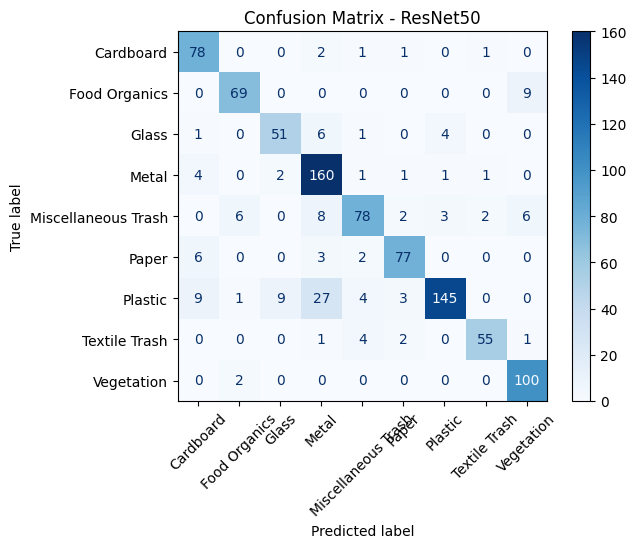

In [ ]:
cm_res = confusion_matrix(y_true_res, y_pred_res)

plt.figure(figsize=(10, 8))
disp_res = ConfusionMatrixDisplay(confusion_matrix=cm_res, display_labels=class_names)
disp_res.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.title("Confusion Matrix - ResNet50")
plt.grid(False)
plt.show()

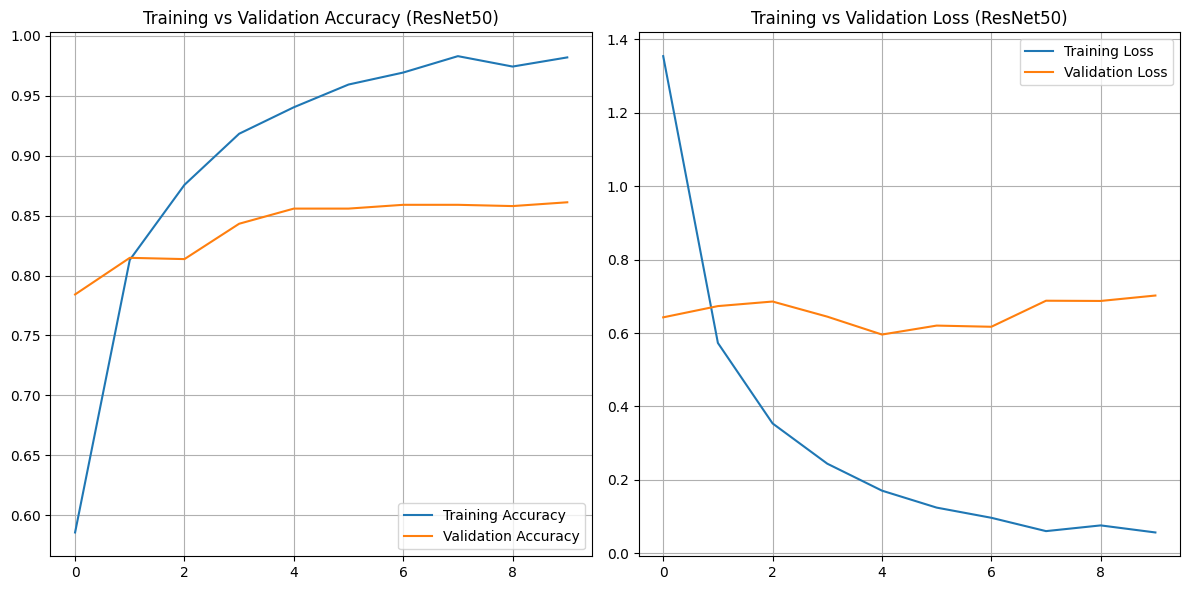

In [ ]:
acc_res = history_res.history['accuracy']
val_acc_res = history_res.history['val_accuracy']
loss_res = history_res.history['loss']
val_loss_res = history_res.history['val_loss']
epochs_range_res = history_res.epoch

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs_range_res, acc_res, label='Training Accuracy')
plt.plot(epochs_range_res, val_acc_res, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training vs Validation Accuracy (ResNet50)')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(epochs_range_res, loss_res, label='Training Loss')
plt.plot(epochs_range_res, val_loss_res, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training vs Validation Loss (ResNet50)')
plt.grid(True)

plt.tight_layout()
plt.show()

## DenseNet121

In [ ]:
def build_densenet_model(num_classes):
    base_model = tf.keras.applications.DenseNet121(
        include_top=False,
        weights='imagenet',
        input_shape=(224, 224, 3)
    )

    base_model.trainable = True
    for layer in base_model.layers[:-10]:
        layer.trainable = False

    inputs = tf.keras.Input(shape=(224, 224, 3))
    x = data_augmentation(inputs)
    x = base_model(x)

    # Modified classifier head
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Flatten()(x)
    x = layers.Dense(1024, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = tf.keras.Model(inputs, outputs)

    model.compile(
        optimizer=tf.keras.optimizers.Adam(1e-4),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

model_des = build_densenet_model(num_classes)
model_des.summary()

EPOCHS = 50

early_stopping_des = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

history_des = model_des.fit(
    train_ds_densenet,
    validation_data=test_ds_densenet,
    epochs=EPOCHS,
    callbacks=[early_stopping_des]
)

model_des.save('/content/model_des.keras')

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ densenet121 (Functional)        │ (None, 7, 7, 1024)     │     7,037,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1024)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 9)              │         9,225 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,100,425 (30.90 MB)

 Trainable params: 1,229,001 (4.69 MB)

 Non-trainable params: 6,871,424 (26.21 MB)

Epoch 1/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 77s 254ms/step - accuracy: 0.3222 - loss: 2.3933 - val_accuracy: 0.6832 - val_loss: 0.9965
Epoch 2/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 21s 174ms/step - accuracy: 0.6367 - loss: 1.0853 - val_accuracy: 0.7737 - val_loss: 0.7262
Epoch 3/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 21s 174ms/step - accuracy: 0.7257 - loss: 0.8314 - val_accuracy: 0.8042 - val_loss: 0.6495
Epoch 4/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 42s 186ms/step - accuracy: 0.7843 - loss: 0.6580 - val_accuracy: 0.8168 - val_loss: 0.6128
Epoch 5/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 21s 174ms/step - accuracy: 0.8065 - loss: 0.5711 - val_accuracy: 0.8179 - val_loss: 0.6165
Epoch 6/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 21s 174ms/step - accuracy: 0.8420 - loss: 0.4558 - val_accuracy: 0.8284 - val_loss: 0.5681
Epoch 7/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 22s 187ms/step - accuracy: 0.8548 - loss: 0.4339 - val_accuracy: 0.8326 - val_loss: 0.5601
Epoch 8/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 21s 177ms/step - accuracy: 0.8654 - loss: 0

In [ ]:
model_des = load_model('/content/model_des.keras')

y_pred_des = model_des.predict(test_ds_densenet)
y_pred_des = np.argmax(y_pred_des, axis=1)
y_true_des = np.concatenate([y for x, y in test_ds_densenet], axis=0)
y_true_des = np.argmax(y_true_des, axis=1)

accuracy_des = np.sum(y_pred_des == y_true_des) / len(y_true_des)
print(f"DenseNet121 Accuracy: {accuracy_des:.4f}")

print("\nClassification Report - DenseNet121")
print(classification_report(y_true_des, y_pred_des, target_names=class_names))


30/30 ━━━━━━━━━━━━━━━━━━━━ 11s 242ms/step
DenseNet121 Accuracy: 0.8821

Classification Report - DenseNet121
                     precision    recall  f1-score   support

          Cardboard       0.80      0.89      0.85        83
      Food Organics       0.95      0.92      0.94        78
              Glass       0.82      0.86      0.84        63
              Metal       0.88      0.91      0.89       170
Miscellaneous Trash       0.88      0.72      0.80       105
              Paper       0.85      0.92      0.89        88
            Plastic       0.91      0.87      0.89       198
      Textile Trash       0.89      0.89      0.89        63
         Vegetation       0.93      0.96      0.95       102

           accuracy                           0.88       950
          macro avg       0.88      0.88      0.88       950
       weighted avg       0.88      0.88      0.88       950



<Figure size 1000x800 with 0 Axes>

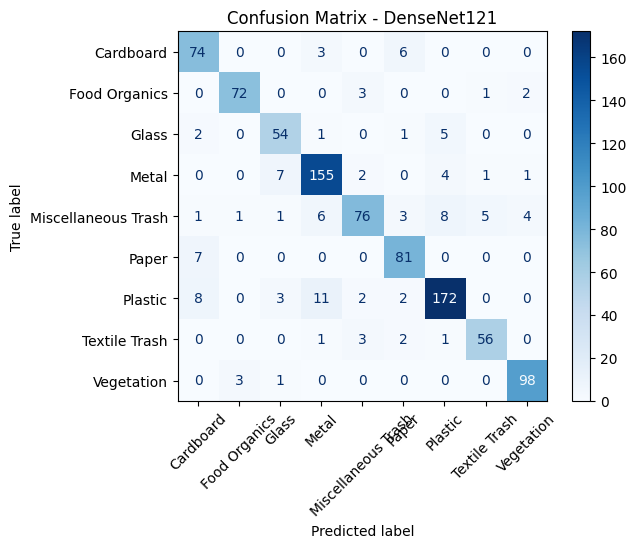

In [ ]:
cm_des = confusion_matrix(y_true_des, y_pred_des)

plt.figure(figsize=(10, 8))
disp_des = ConfusionMatrixDisplay(confusion_matrix=cm_des, display_labels=class_names)
disp_des.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.title("Confusion Matrix - DenseNet121")
plt.grid(False)
plt.show()

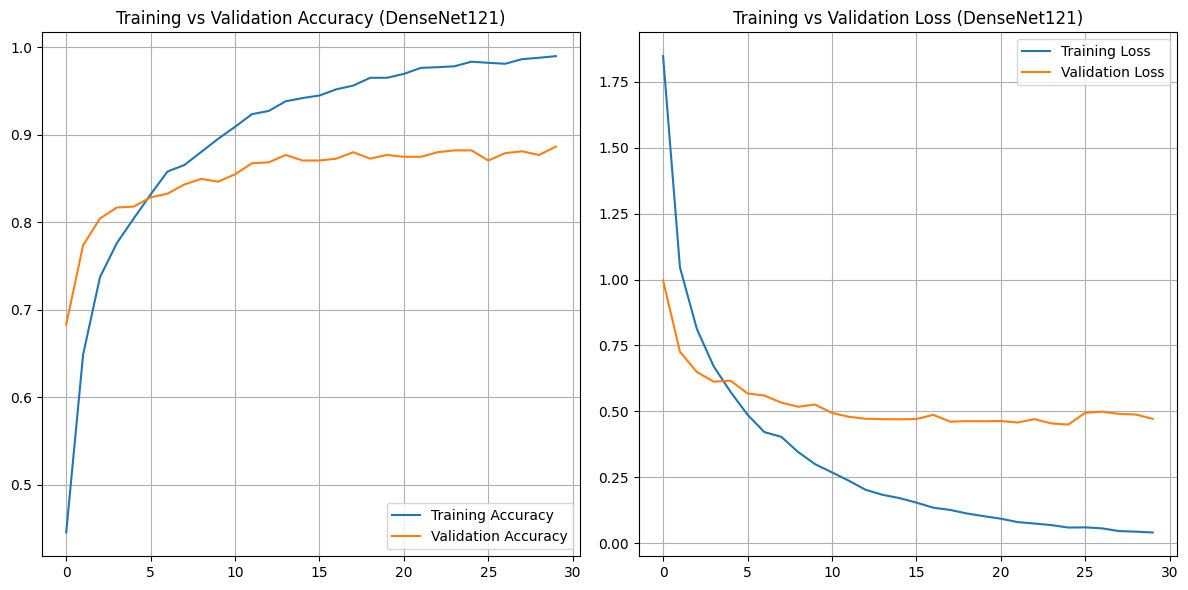

In [ ]:
acc_des = history_des.history['accuracy']
val_acc_des = history_des.history['val_accuracy']
loss_des = history_des.history['loss']
val_loss_des = history_des.history['val_loss']
epochs_range_des = history_des.epoch

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs_range_des, acc_des, label='Training Accuracy')
plt.plot(epochs_range_des, val_acc_des, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training vs Validation Accuracy (DenseNet121)')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(epochs_range_des, loss_des, label='Training Loss')
plt.plot(epochs_range_des, val_loss_des, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training vs Validation Loss (DenseNet121)')
plt.grid(True)

plt.tight_layout()
plt.show()

## VGG16

In [ ]:
def build_vgg_model(num_classes):
    base_model = tf.keras.applications.VGG16(
        include_top=False,
        weights='imagenet',
        input_shape=(224, 224, 3)
    )

    base_model.trainable = True
    for layer in base_model.layers[:-8]:  # More conservative unfreezing for VGG
        layer.trainable = False

    inputs = tf.keras.Input(shape=(224, 224, 3))
    x = data_augmentation(inputs)
    x = base_model(x)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Flatten()(x)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = tf.keras.Model(inputs, outputs)

    model.compile(
        optimizer=tf.keras.optimizers.Adam(1e-5),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

model_vgg = build_vgg_model(num_classes)
model_vgg.summary()

early_stopping_vgg = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=2,
    min_lr=1e-7
)

history_vgg = model_vgg.fit(
    train_ds_vgg,
    validation_data=test_ds_vgg,
    epochs=EPOCHS,
    callbacks=[early_stopping_vgg, reduce_lr]
)


model_vgg.save('/content/model_vgg.keras')

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_24"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 9)              │         4,617 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,984,009 (57.16 MB)

 Trainable params: 13,247,497 (50.54 MB)

 Non-trainable params: 1,736,512 (6.62 MB)

Epoch 1/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 63s 327ms/step - accuracy: 0.2000 - loss: 2.8655 - val_accuracy: 0.3421 - val_loss: 2.4704 - learning_rate: 1.0000e-05
Epoch 2/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 55s 264ms/step - accuracy: 0.4270 - loss: 1.7369 - val_accuracy: 0.5453 - val_loss: 1.5009 - learning_rate: 1.0000e-05
Epoch 3/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 32s 273ms/step - accuracy: 0.5315 - loss: 1.4047 - val_accuracy: 0.6368 - val_loss: 1.1174 - learning_rate: 1.0000e-05
Epoch 4/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 31s 259ms/step - accuracy: 0.6006 - loss: 1.1679 - val_accuracy: 0.7516 - val_loss: 0.8224 - learning_rate: 1.0000e-05
Epoch 5/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 31s 262ms/step - accuracy: 0.6630 - loss: 1.0157 - val_accuracy: 0.7263 - val_loss: 0.8360 - learning_rate: 1.0000e-05
Epoch 6/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 31s 262ms/step - accuracy: 0.6969 - loss: 0.9090 - val_accuracy: 0.6768 - val_loss: 1.0644 - learning_rate: 1.0000e-05
Epoch 7/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 31s 26

In [ ]:
model_vgg = load_model('/content/model_vgg.keras')

y_pred_vgg = model_vgg.predict(test_ds_vgg)
y_pred_vgg = np.argmax(y_pred_vgg, axis=1)
y_true_vgg = np.concatenate([y for x, y in test_ds_vgg], axis=0)
y_true_vgg = np.argmax(y_true_vgg, axis=1)

accuracy_vgg = np.sum(y_pred_vgg == y_true_vgg) / len(y_true_vgg)
print(f"VGG16 Accuracy: {accuracy_vgg:.4f}")

print("\nClassification Report - VGG16")
print(classification_report(y_true_vgg, y_pred_vgg, target_names=class_names))

30/30 ━━━━━━━━━━━━━━━━━━━━ 5s 150ms/step
VGG16 Accuracy: 0.7516

Classification Report - VGG16
                     precision    recall  f1-score   support

          Cardboard       0.69      0.84      0.76        83
      Food Organics       0.76      0.87      0.81        78
              Glass       0.77      0.65      0.71        63
              Metal       0.77      0.82      0.79       170
Miscellaneous Trash       0.65      0.44      0.52       105
              Paper       0.79      0.72      0.75        88
            Plastic       0.80      0.75      0.77       198
      Textile Trash       0.75      0.63      0.69        63
         Vegetation       0.74      0.96      0.84       102

           accuracy                           0.75       950
          macro avg       0.75      0.74      0.74       950
       weighted avg       0.75      0.75      0.74       950



<Figure size 1000x800 with 0 Axes>

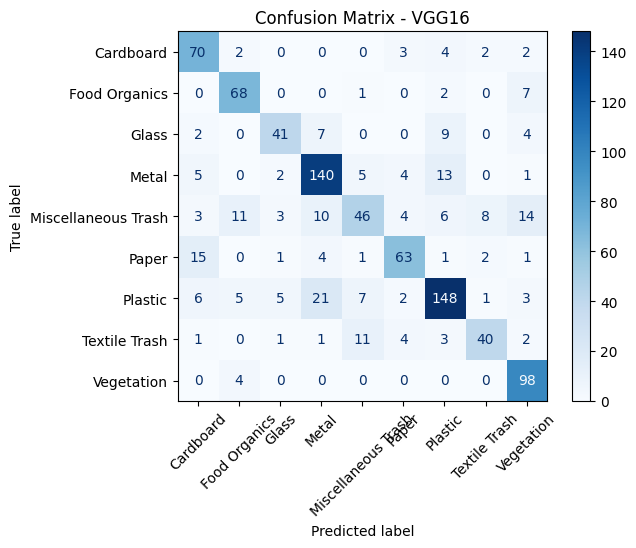

In [ ]:
cm_vgg = confusion_matrix(y_true_vgg, y_pred_vgg)

plt.figure(figsize=(10, 8))
disp_vgg = ConfusionMatrixDisplay(confusion_matrix=cm_vgg, display_labels=class_names)
disp_vgg.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.title("Confusion Matrix - VGG16")
plt.grid(False)
plt.show()

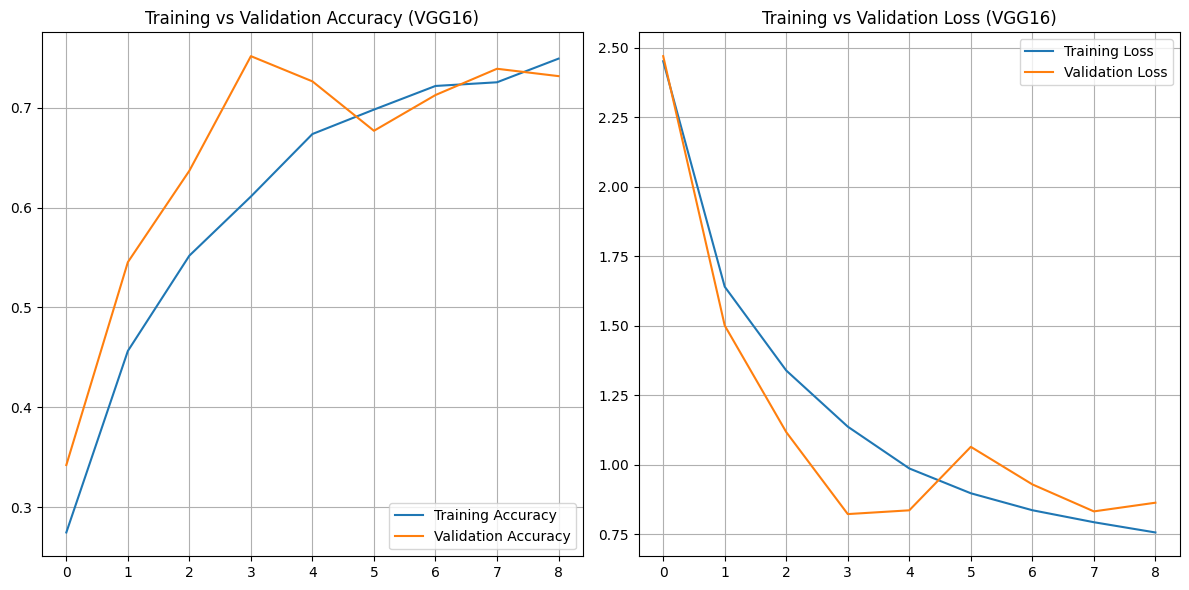

In [ ]:
acc_vgg = history_vgg.history['accuracy']
val_acc_vgg = history_vgg.history['val_accuracy']
loss_vgg = history_vgg.history['loss']
val_loss_vgg = history_vgg.history['val_loss']
epochs_range_vgg = range(len(acc_vgg))

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs_range_vgg, acc_vgg, label='Training Accuracy')
plt.plot(epochs_range_vgg, val_acc_vgg, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training vs Validation Accuracy (VGG16)')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(epochs_range_vgg, loss_vgg, label='Training Loss')
plt.plot(epochs_range_vgg, val_loss_vgg, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training vs Validation Loss (VGG16)')
plt.grid(True)

plt.tight_layout()
plt.show()

# Analisis

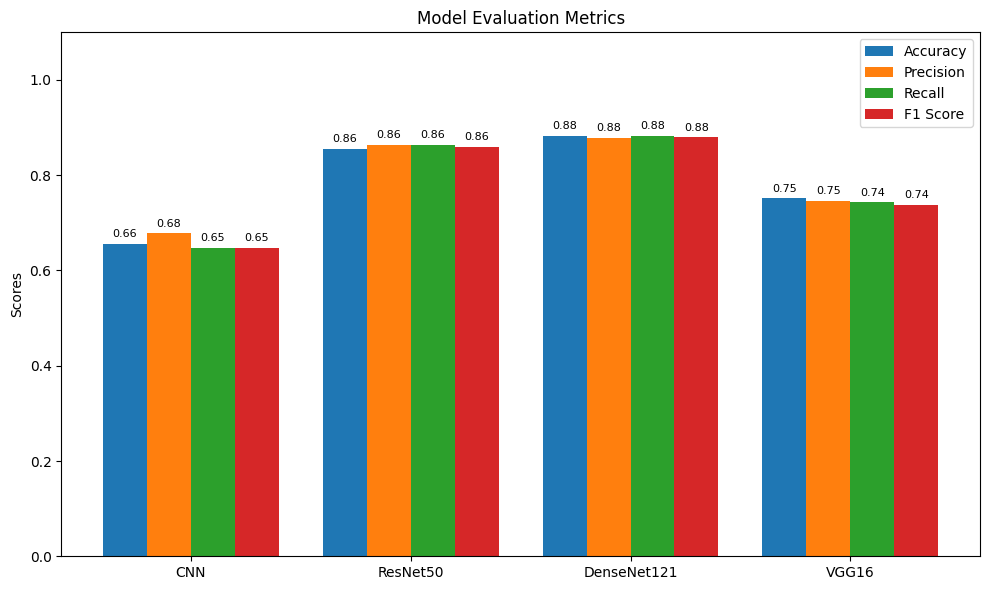

In [ ]:
results = {
    'CNN': (y_true, y_pred),
    'ResNet50': (y_true_res, y_pred_res),
    'DenseNet121': (y_true_des, y_pred_des),
    'VGG16': (y_true_vgg, y_pred_vgg)
}

model_names = []
accuracies = []
precisions = []
recalls = []
f1s = []

for name, (y_true_, y_pred_) in results.items():
    model_names.append(name)
    accuracies.append(np.mean(y_true_ == y_pred_))
    precisions.append(precision_score(y_true_, y_pred_, average='macro'))
    recalls.append(recall_score(y_true_, y_pred_, average='macro'))
    f1s.append(f1_score(y_true_, y_pred_, average='macro'))

# Convert to numpy arrays for easy plotting
metrics = np.array([accuracies, precisions, recalls, f1s])
metric_names = ['Accuracy', 'Precision', 'Recall', 'F1 Score']

x = np.arange(len(model_names))  # the label locations
width = 0.2  # width of the bars

fig, ax = plt.subplots(figsize=(10, 6))
for i in range(len(metric_names)):
    ax.bar(x + i*width, metrics[i], width, label=metric_names[i])

# Add text on bars
for i in range(len(metric_names)):
    for j in range(len(model_names)):
        val = metrics[i][j]
        ax.text(x[j] + i*width, val + 0.01, f"{val:.2f}", ha='center', va='bottom', fontsize=8)

ax.set_ylabel('Scores')
ax.set_title('Model Evaluation Metrics')
ax.set_xticks(x + width * 1.5)
ax.set_xticklabels(model_names)
ax.set_ylim(0, 1.1)
ax.legend()

plt.tight_layout()
plt.show()


### Analisis Lanjutan
Dari hasil pelatihan, terlihat perbedaan signifikan antara custom CNN dan model berbasis transfer learning (ResNet50, DenseNet121, dan VGG16). Custom CNN hanya mencapai akurasi validasi 65,58%, sementara model pre-trained seperti ResNet (85,58%), DenseNet (88,21%), dan VGG16 (75,16%) menunjukkan performa yang jauh lebih baik. Hal ini mengindikasikan bahwa kemampuan ekstraksi fitur dari model pre-trained jauh lebih efektif dalam mengenali pola kompleks pada data sampah dibandingkan custom CNN.

Beberapa poin analisis lebih lanjut:
1. Overfitting pada Custom CNN
  
  Meskipun akurasi pelatihan terus meningkat (mencapai 76,66%), akurasi validasi stagnan di kisaran 65%. Hal ini menunjukkan bahwa model kurang mampu beradaptasi ke data baru, kemungkinan karena kurangnya teknik regularisasi atau kedalaman arsitektur yang tidak mencukupi serta Kurangnya mekanisme advanced seperti batch normalization, residual connections, atau dense blocks membuat model sulit mengekstrak fitur secara optimal.

2. DenseNet121
  
  DenseNet121 mencapai akurasi tertinggi (88,21%) dengan F1-score yang konsisten di semua kelas. Performa terbaik terutama terlihat pada kelas Vegetation (F1: 0,95) dan Food Organics (F1: 0,94), menunjukkan kemampuan yang baik dalam mengenali sampah organik.

3. ResNet50
  
  ResNet50 mencapai akurasi >80% hanya dalam 2 epoch, menunjukkan efisiensi pembelajaran yang tinggi berkat skip connections. Namun, akurasi validasi cenderung stagnan setelah epoch ke-5, menandakan bahwa model mungkin sudah mencapai kapasitas maksimalnya.

4. VGG16
  
  VGG16 lebih baik dari custom CNN tetapi kalah dibanding ResNet/DenseNet, kemungkinan karena arsitekturnya kurang efisien serta masih mengalami kesulitan pada kelas seperti Miscellaneous Trash (F1: 0,52).

#### Kesimpulan:

Secara keseluruhan, hasil ini membuktikan bahwa transfer learning secara signifikan meningkatkan akurasi klasifikasi untuk tugas pengelompokan sampah ini. Jika ingin performa lebih optimal, penggunaan model pre-trained seperti DenseNet121 atau ResNet50 lebih direkomendasikan.

